In [9]:
import pandas as pd
import numpy as np
from sklearn.metrics import (
    auc,
    confusion_matrix,
    precision_recall_curve,
    roc_curve,
    r2_score,
)
import matplotlib
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

In [10]:

def plot_sel_coeff_preds(data, dtype, name, outdir, scenarios):
    """Plot s predictions against true value, color by scenario."""
    if "ssv" in name:
        true_class = "ssv"
    elif "sdn" in name:
        true_class = "sdn"

    plt.scatter(
        data["true_sel_coeff"], data["pred_sel_coeff"], label=true_class.upper()
    )
    plt.annotate(
        f"""r^2 of {true_class.upper()}: {np.round(r2_score(data["true_sel_coeff"], data["pred_sel_coeff"]), 2)}""",
        (0.05, 0.27),
    )

    plt.legend()
    plt.xlim((0, 0.3))
    plt.ylim((0, 0.3))
    plt.title(f"{name} \n Predicted vs True Selection Coefficients")
    plt.ylabel("Predicted S")
    plt.xlabel("True S")

    plt.savefig(
        f"{outdir}/{name.replace(' ', '_')}_Timesweeper_Reg_{dtype}_selcoeffs.png", dpi=3000
    )
    plt.savefig(
        f"{outdir}/{name.replace(' ', '_')}_Timesweeper_Reg_{dtype}_selcoeffs.png", dpi=3000
    )
    plt.clf()


def plot_confusion_matrix(
    cm, target_names, title="Confusion matrix", cmap=None, normalize=True
):
    """
    Given a sklearn confusion matrix (cm), make a nice plot.

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap("Blues")

    outfile = title
    title = title.split("_Timesweeper")[0] + " Confusion Matrix"

    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(
                j,
                i,
                f"{cm[i, j]:0.4f}",
                horizontalalignment="center",
                color="black",
                # color="white" if cm[i, j] > thresh else "black",
            )
        else:
            plt.text(
                j,
                i,
                f"{cm[i, j]:,}",
                horizontalalignment="center",
                color="black",
                # color="white" if cm[i, j] > thresh else "black",
            )

    plt.ylabel("True label")
    plt.xlabel(f"Predicted label\naccuracy={accuracy:0.4f}; misclass={misclass:0.4f}")
    plt.savefig(f"{title}_confmat.pdf")

# Adapt the single-plots from plotting.plotting_utils to iteratively plot curves
def plot_roc(name, data, dtype, outdir):
    """Plot ROC curve by binarizing neutral/sweep."""

    # Plot sdn/ssv distinction
    sweep_idxs = np.transpose(np.array((data["true"] > 0)).nonzero())
    sweep_labs = np.array(data["true"])[sweep_idxs]

    sdn_probs = data[data["true"] > 0]["sdn_prob"]

    swp_fpr, swp_tpr, thresh = roc_curve(sweep_labs, sdn_probs, pos_label=2)
    swp_auc_val = auc(swp_fpr, swp_tpr)
    plt.plot(
        swp_fpr,
        swp_tpr,
        label=f"{name.capitalize()} AUC: {swp_auc_val:.4}",
    )

    # Coerce all ssvs into sweep binary pred
    labs = np.array(data["true"])
    labs[labs > 1] = 1
    pred_probs = np.sum(np.array([data["sdn_prob"], data["ssv_prob"]]).T, axis=1)

    # Plot ROC Curve
    fpr, tpr, thresh = roc_curve(labs, pred_probs)
    auc_val = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name.capitalize()}AUC: {auc_val:.2}")
    
    plt.ylim((0,1.1))
    plt.xlim((0,1.1))
    plt.title(f"ROC Curve {name}")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.legend()


def plot_prec_recall(name, data, dtype, outdir):
    """Plot PR curve by binarizing neutral/sweep."""
    # Plot sdn/ssv distinction

    filt_data = data[(data["sdn_prob"] > 0.0) & (data["ssv_prob"] > 0.0)]

    sweep_idxs = np.transpose(np.array((filt_data["true"] > 0)).nonzero())
    sweep_labs = np.array(filt_data["true"])[sweep_idxs]

    # TODO FIX THIS: divide score of sweep by summed sweep prob
    # TODO FIlter out where probs of both prob are 0
    if len(np.unique(filt_data["true"])) > 2:
        sdn_probs = filt_data[filt_data["true"] > 0]["sdn_prob"] / (
            filt_data[filt_data["true"] > 0]["sdn_prob"]
            + filt_data[filt_data["true"] > 0]["ssv_prob"]
        )

        swp_prec, swp_rec, swp_thresh = precision_recall_curve(
            sweep_labs.flatten(), sdn_probs, pos_label=2
        )
        swp_auc_val = auc(swp_rec, swp_prec)
        plt.plot(
            swp_rec,
            swp_prec,
            label=f"{name.capitalize()} AUC: {swp_auc_val:.2}",
        )

    # Coerce all ssvs into sweep binary pred
    labs = np.array(data["true"])
    labs[labs > 1] = 1
    pred_probs = np.sum(np.array([data["sdn_prob"], data["ssv_prob"]]).T, axis=1)

    # Plot PR Curve for binarized labs
    prec, rec, thresh = precision_recall_curve(labs, pred_probs)
    auc_val = auc(rec, prec)
    plt.plot(rec, prec, label=f"{name.capitalize()} Neutral vs Sweep AUC: {auc_val:.2}")

    plt.title(f"PR Curve {name}")
    plt.legend()
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.ylim((0,1.1))
    plt.xlim((0,1.1))


In [11]:
ts = pd.read_csv("ts_res/ts_centers/aft_Timesweeper_res.csv")
ts_hft = pd.read_csv("ts_res/ts_centers/hft_Timesweeper_res.csv")
sf = pd.read_csv("sf_res/sf_res.csv")
shic_final = pd.read_csv("shic_final_res/shic_res.csv")
shic_ts = pd.read_csv("shic_tp_res/TP_SHIC_res.csv")
slattice = pd.read_csv("slattice_res/slattice_output.csv")
appwf = pd.read_csv("wfapp_results/appwf_res.csv")
wfabc = pd.read_csv("wfabc_res/wfabc.csv")

In [12]:
appwf = appwf[(appwf["s_val"] != 0.0) & (appwf["sweep"] != "neut")] 
appwf.head()


,rep,sweep,s_val,estimated_s_mean,est_std
5001,0,sdn,0.193895,0.178550,0.034944
5002,1,sdn,0.081233,0.000854,0.005255
5003,10,sdn,0.138902,0.129281,0.025430
5004,100,sdn,0.079220,0.079132,0.016977
5005,1001,sdn,0.018688,0.000088,0.003972


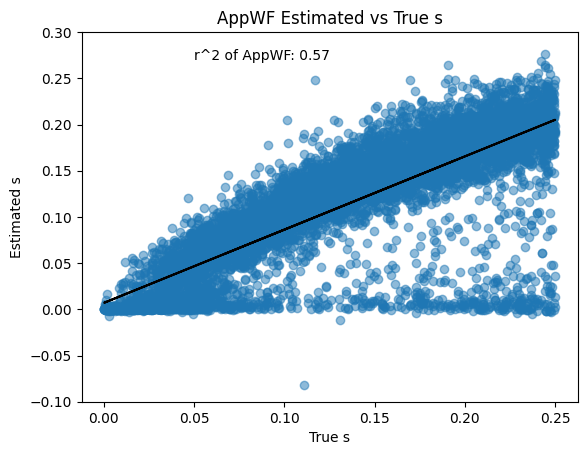

In [13]:
x = appwf["s_val"]
y = appwf["estimated_s_mean"]

plt.scatter(x, y, alpha=0.5) 
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x+b, "-", color="black")

plt.ylim((-0.1, 0.3))   
plt.annotate(
        f"""r^2 of AppWF: {np.round(r2_score(x, y), 2)}""",
        (0.05, 0.27),
    )
plt.xlabel("True s")
plt.ylabel("Estimated s")
plt.title("AppWF Estimated vs True s")
plt.savefig("appwf_selcoeffs.png")


In [14]:
wfabc = wfabc[(wfabc["s_val"] != 0.0) & (wfabc["sweep"] != "neut")] 

wfabc.dropna(inplace=True)
wfabc = wfabc[wfabc["sweep"] != "neut"]
wfabc.head()


,rep,sweep,s_val,estimated_s_mean,est_std
4996,0,sdn,0.068915,0.045691,0.036437
4997,1,sdn,0.143512,0.106145,0.039729
4998,10,sdn,0.120995,0.157122,0.047257
4999,100,sdn,0.091992,0.105670,0.043313
5000,1001,sdn,0.221360,0.136518,0.051310


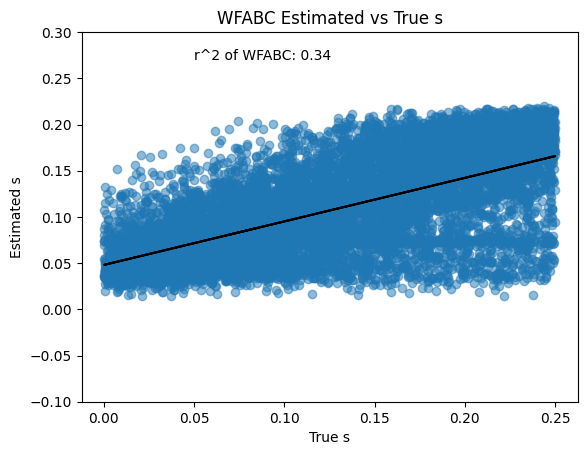

In [15]:
#WFABC
x = wfabc["s_val"]
y = wfabc["estimated_s_mean"]

plt.scatter(x, y, alpha=0.5) 
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x+b, "-", color="black")

plt.ylim((-0.1, 0.3))   
plt.annotate(
        f"""r^2 of WFABC: {np.round(r2_score(x, y), 2)}""",
        (0.05, 0.27),
    )
plt.xlabel("True s")
plt.ylabel("Estimated s")
plt.title("WFABC Estimated vs True s")
plt.savefig("wfabc_selcoeffs.png", dpi=3000)


In [16]:
lab_dict = {"neut": 0, "sdn": 1, "ssv": 2}
ts["swp_str"] = [lab_dict[i] for i in ts["sweep"]]
class_ts = ts
ts.head()


,rep,sweep,pred_sweep,neut_prob,sdn_prob,ssv_prob,s_val,sdn_sval,ssv_sval,swp_str
0,0,neut,0,0.936352,0.060216,0.003432,0.0,0.025517,0.092548,0
1,1,neut,0,0.954407,0.038212,0.007381,0.0,0.025952,0.092127,0
2,10,neut,0,0.919221,0.072434,0.008344,0.0,0.026199,0.143294,0
3,100,neut,0,0.921702,0.051802,0.026496,0.0,0.025430,0.124717,0
4,1001,neut,0,0.916868,0.080679,0.002453,0.0,0.026534,0.130963,0


In [17]:
ts = ts[ts["sweep"] != "neut"]
ts.loc[:, "est_s"] = np.zeros(len(ts))
ts.loc[ts["swp_str"] == 1, "est_s"] = ts["sdn_sval"]
ts.loc[ts["swp_str"] == 2, "est_s"] = ts["ssv_sval"]
ts.head()

/tmp/ipykernel_3592156/4138791299.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts.loc[:, "est_s"] = np.zeros(len(ts))


,rep,sweep,pred_sweep,neut_prob,sdn_prob,ssv_prob,s_val,sdn_sval,ssv_sval,swp_str,est_s
5046,0,sdn,2,0.004559,0.288438,0.707003,0.068915,0.064697,0.057812,1,0.064697
5047,1,sdn,2,0.001437,0.470365,0.528198,0.143512,0.146084,0.137504,1,0.146084
5048,10,sdn,2,0.002481,0.408976,0.588544,0.120995,0.104860,0.121152,1,0.104860
5049,100,sdn,1,0.006268,0.674566,0.319166,0.091992,0.111359,0.103496,1,0.111359
5050,1001,sdn,2,0.000494,0.453323,0.546183,0.221360,0.177149,0.194274,1,0.177149


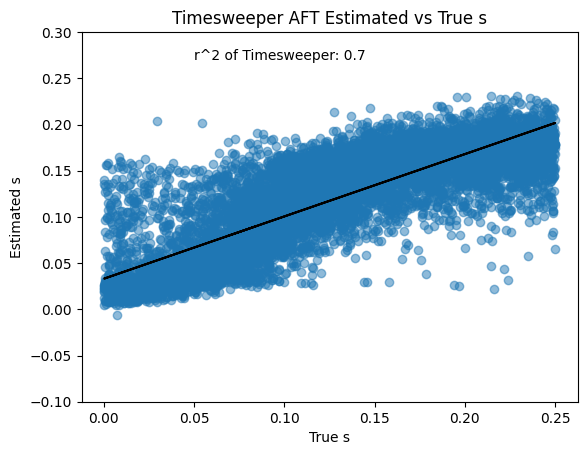

In [18]:
#Timesweeper
x = ts["s_val"]
y = ts["est_s"]

plt.scatter(x, y, alpha=0.5) 
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x+b, "-", color="black")

plt.ylim((-0.1, 0.3))   
plt.annotate(
        f"""r^2 of Timesweeper: {np.round(r2_score(x, y), 2)}""",
        (0.05, 0.27),
    )
plt.xlabel("True s")
plt.ylabel("Estimated s")
plt.title("Timesweeper AFT Estimated vs True s")
plt.savefig("timesweeper_selcoeffs.png", dpi=3000)


In [19]:
lab_dict = {"neut": 0, "sdn": 1, "ssv": 2}
ts_hft["swp_str"] = [lab_dict[i] for i in ts_hft["sweep"]]
class_ts = ts_hft
ts_hft.head()

,rep,sweep,pred_sweep,neut_prob,sdn_prob,ssv_prob,s_val,sdn_sval,ssv_sval,swp_str
0,0,neut,0,0.547223,0.415892,0.036884,0.0,0.107550,0.105517,0
1,1,neut,0,0.739645,0.211936,0.048419,0.0,0.033391,0.091126,0
2,10,neut,0,0.694541,0.251333,0.054126,0.0,0.032381,0.086200,0
3,100,neut,0,0.537459,0.255243,0.207298,0.0,0.035317,0.082477,0
4,1001,neut,0,0.744271,0.201530,0.054198,0.0,0.030337,0.081328,0


In [20]:
ts_hft = ts_hft[ts_hft["sweep"] != "neut"]
ts_hft.loc[:, "est_s"] = np.zeros(len(ts_hft))
ts_hft.loc[ts_hft["swp_str"] == 1, "est_s"] = ts_hft["sdn_sval"]
ts_hft.loc[ts_hft["swp_str"] == 2, "est_s"] = ts_hft["ssv_sval"]
ts_hft.head()

/tmp/ipykernel_3592156/1601274946.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts_hft.loc[:, "est_s"] = np.zeros(len(ts_hft))


,rep,sweep,pred_sweep,neut_prob,sdn_prob,ssv_prob,s_val,sdn_sval,ssv_sval,swp_str,est_s
5044,0,sdn,0,0.454136,0.244916,0.300947,0.068915,0.039298,0.081987,1,0.039298
5045,1,sdn,1,0.026855,0.682390,0.290756,0.143512,0.136583,0.129481,1,0.136583
5046,10,sdn,2,0.002944,0.301391,0.695665,0.120995,0.140518,0.102638,1,0.140518
5047,100,sdn,1,0.272708,0.617673,0.109619,0.091992,0.083938,0.101073,1,0.083938
5048,1001,sdn,1,0.017091,0.533126,0.449783,0.221360,0.167909,0.125287,1,0.167909


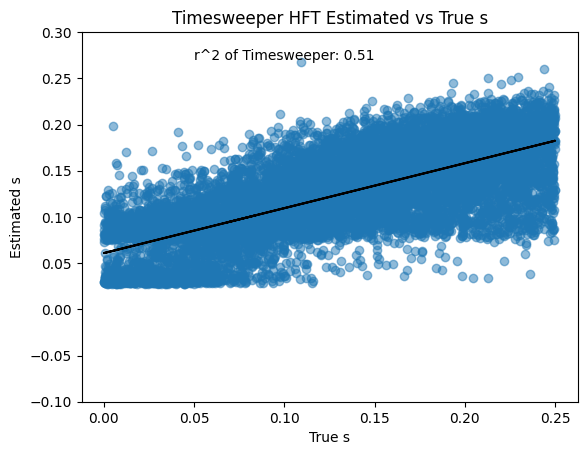

In [21]:
#Timesweeper HFT
x = ts_hft["s_val"]
y = ts_hft["est_s"]

plt.scatter(x, y, alpha=0.5) 
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x+b, "-", color="black")

plt.ylim((-0.1, 0.3))   
plt.annotate(
        f"""r^2 of Timesweeper: {np.round(r2_score(x, y), 2)}""",
        (0.05, 0.27),
    )
plt.xlabel("True s")
plt.ylabel("Estimated s")
plt.title("Timesweeper HFT Estimated vs True s")
plt.savefig("timesweeper_hft_selcoeffs.png", dpi=3000)


In [22]:
slattice = slattice[slattice["sweep"] != "neut"]
slattice.head()


,rep,sweep,s_val,estimated_sval
4568,0,sdn,0.193895,0.081993
4569,1,sdn,0.081233,0.008785
4570,10,sdn,0.138902,0.060678
4571,100,sdn,0.079220,0.036768
4572,1001,sdn,0.018688,-0.000251


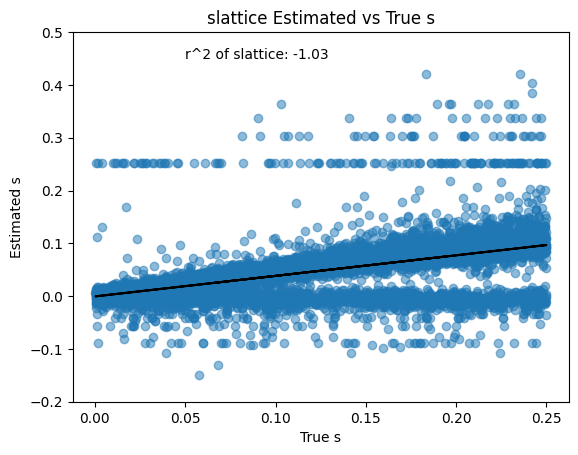

In [23]:
#Slattice
x = slattice["s_val"]
y = slattice["estimated_sval"]

plt.scatter(x, y, alpha=0.5) 
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x+b, "-", color="black")

plt.ylim((-0.2, 0.5))   
plt.annotate(
        f"""r^2 of slattice: {np.round(r2_score(x, y), 2)}""",
        (0.05, 0.45),
    )
plt.xlabel("True s")
plt.ylabel("Estimated s")
plt.title("slattice Estimated vs True s")
plt.savefig("slattice_selcoeffs.png", dpi=3000)


In [24]:
lab_dict = {"neut": 0, "sdn": 1, "ssv": 2}
shic_ts["swp_str"] = [lab_dict[i] for i in shic_ts["sweep"]]
shic_ts.head()


,rep,sweep,selcoeff,pred_class,neut_prob,sdn_prob,ssv_prob,sdn_pred_s,ssv_pred_s,swp_str
0,0,neut,0.000000,0,0.504393,0.232063,0.263545,0.079339,0.048689,0
1,0,sdn,0.193895,1,0.016751,0.622572,0.360677,0.133404,0.126946,1
2,0,ssv,0.038933,0,0.472213,0.247185,0.280602,0.067298,0.056548,2
3,1,neut,0.000000,0,0.522556,0.226185,0.251259,0.061646,0.050781,0
4,1,sdn,0.081233,0,0.413132,0.238301,0.348568,0.105258,0.088421,1


In [25]:
class_shic_ts = shic_ts

shic_ts["est_s"] = np.zeros(len(shic_ts))
shic_ts = shic_ts[shic_ts["sweep"] != "neut"]
shic_ts.loc[shic_ts["swp_str"] == 1, "est_s"] = shic_ts["sdn_pred_s"]
shic_ts.loc[shic_ts["swp_str"] == 2, "est_s"] = shic_ts["ssv_pred_s"]
shic_ts.head()

,rep,sweep,selcoeff,pred_class,neut_prob,sdn_prob,ssv_prob,sdn_pred_s,ssv_pred_s,swp_str,est_s
1,0,sdn,0.193895,1,0.016751,0.622572,0.360677,0.133404,0.126946,1,0.133404
2,0,ssv,0.038933,0,0.472213,0.247185,0.280602,0.067298,0.056548,2,0.056548
4,1,sdn,0.081233,0,0.413132,0.238301,0.348568,0.105258,0.088421,1,0.105258
5,1,ssv,0.045940,0,0.616903,0.160739,0.222359,0.066544,0.050288,2,0.050288
7,2,sdn,0.149065,1,0.021531,0.497518,0.480951,0.177966,0.166546,1,0.177966


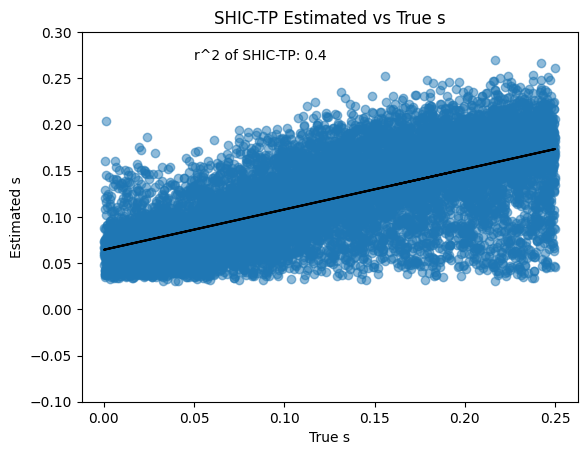

In [26]:
#Shic-TP
x = shic_ts["selcoeff"]
y = shic_ts["est_s"]

plt.scatter(x, y, alpha=0.5) 
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x+b, "-", color="black")

plt.ylim((-0.1, 0.3))   
plt.annotate(
        f"""r^2 of SHIC-TP: {np.round(r2_score(x, y), 2)}""",
        (0.05, 0.27),
    )
plt.xlabel("True s")
plt.ylabel("Estimated s")
plt.title("SHIC-TP Estimated vs True s")
plt.savefig("shic_tp_selcoeffs.png", dpi=3000)


In [27]:
ts = pd.read_csv("ts_res/ts_centers/aft_Timesweeper_res.csv")
ts_hft = pd.read_csv("ts_res/ts_centers/hft_Timesweeper_res.csv")
sf = pd.read_csv("sf_res/sf_res.csv")
shic_final = pd.read_csv("shic_final_res/shic_res.csv")
shic_ts = pd.read_csv("shic_tp_res/TP_SHIC_res.csv")
stat_mets = pd.read_csv("stat_methods/stat_res.csv")

In [28]:
ts["swp_str"] = [lab_dict[i] for i in ts["sweep"]]
ts.head()

,rep,sweep,pred_sweep,neut_prob,sdn_prob,ssv_prob,s_val,sdn_sval,ssv_sval,swp_str
0,0,neut,0,0.936352,0.060216,0.003432,0.0,0.025517,0.092548,0
1,1,neut,0,0.954407,0.038212,0.007381,0.0,0.025952,0.092127,0
2,10,neut,0,0.919221,0.072434,0.008344,0.0,0.026199,0.143294,0
3,100,neut,0,0.921702,0.051802,0.026496,0.0,0.025430,0.124717,0
4,1001,neut,0,0.916868,0.080679,0.002453,0.0,0.026534,0.130963,0


[0.06364761 0.04559312 0.08077883 ... 0.47391121 0.97607208 0.44042471]
[0 0 0 ... 1 1 1]


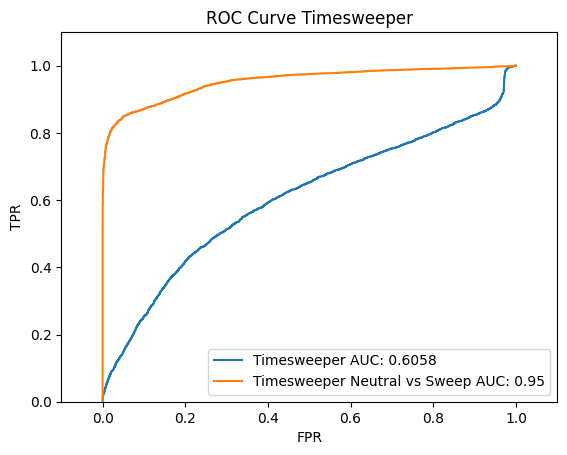

In [29]:
#Timesweeper
sweep_idxs = np.transpose(np.array((ts["swp_str"] > 0)).nonzero())
sweep_labs = np.array(ts["swp_str"])[sweep_idxs]

sdn_probs = ts[ts["swp_str"] > 0]["sdn_prob"]

swp_fpr, swp_tpr, thresh = roc_curve(sweep_labs, sdn_probs, pos_label=2)
swp_auc_val = auc(swp_fpr, swp_tpr)
plt.plot(
    swp_fpr,
    swp_tpr,
    label=f"Timesweeper AUC: {swp_auc_val:.4}",
)

# Coerce all ssvs into sweep binary pred
labs = np.array(ts["swp_str"])
labs[labs > 1] = 1
pred_probs = np.sum(np.array([ts["sdn_prob"], ts["ssv_prob"]]).T, axis=1)
print(pred_probs)
print(labs)
# Plot ROC Curve
fpr, tpr, thresh = roc_curve(labs, pred_probs)
auc_val = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"Timesweeper Neutral vs Sweep AUC: {auc_val:.2}")

plt.ylim((0,1.1))
plt.xlim((-0.1, 1.1))
plt.title(f"ROC Curve Timesweeper")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()


In [30]:
ts["sweep_true"] = np.where(ts["swp_str"] > 0, 1, 0)
ts["sweep_pred"] = np.where(ts["pred_sweep"] > 0, 1, 0)
#plot_confusion_matrix( confusion_matrix(ts["sweep_true"], ts["sweep_pred"]), labels=["Neutral", "Sweep"], title="Timesweeper AFT", cmap=None, normalize=True)

In [31]:
ts_hft["swp_str"] = [lab_dict[i] for i in ts_hft["sweep"]]
ts_hft.head()

,rep,sweep,pred_sweep,neut_prob,sdn_prob,ssv_prob,s_val,sdn_sval,ssv_sval,swp_str
0,0,neut,0,0.547223,0.415892,0.036884,0.0,0.107550,0.105517,0
1,1,neut,0,0.739645,0.211936,0.048419,0.0,0.033391,0.091126,0
2,10,neut,0,0.694541,0.251333,0.054126,0.0,0.032381,0.086200,0
3,100,neut,0,0.537459,0.255243,0.207298,0.0,0.035317,0.082477,0
4,1001,neut,0,0.744271,0.201530,0.054198,0.0,0.030337,0.081328,0


[0.45277647 0.26035475 0.30545893 ... 0.28098581 0.93702793 0.30166202]
[0 0 0 ... 1 1 1]


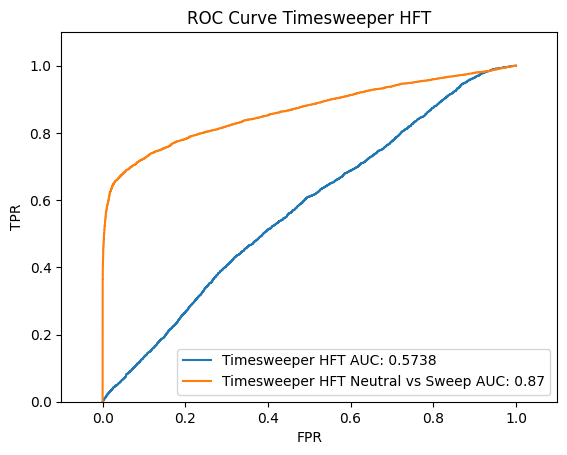

In [32]:
#Timesweeper
sweep_idxs = np.transpose(np.array((ts_hft["swp_str"] > 0)).nonzero())
sweep_labs = np.array(ts_hft["swp_str"])[sweep_idxs]

sdn_probs = ts_hft[ts_hft["swp_str"] > 0]["sdn_prob"]

swp_fpr, swp_tpr, thresh = roc_curve(sweep_labs, sdn_probs, pos_label=2)
swp_auc_val = auc(swp_fpr, swp_tpr)
plt.plot(
    swp_fpr,
    swp_tpr,
    label=f"Timesweeper HFT AUC: {swp_auc_val:.4}",
)

# Coerce all ssvs into sweep binary pred
labs = np.array(ts_hft["swp_str"])
labs[labs > 1] = 1
pred_probs = np.sum(np.array([ts_hft["sdn_prob"], ts_hft["ssv_prob"]]).T, axis=1)
print(pred_probs)
print(labs)
# Plot ROC Curve
fpr, tpr, thresh = roc_curve(labs, pred_probs)
auc_val = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"Timesweeper HFT Neutral vs Sweep AUC: {auc_val:.2}")

plt.ylim((0,1.1))
plt.xlim((-0.1, 1.1))
plt.title(f"ROC Curve Timesweeper HFT")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()

In [33]:
ts_hft["sweep_true"] = np.where(ts_hft["swp_str"] > 0, 1, 0)
ts_hft["sweep_pred"] = np.where(ts_hft["pred_sweep"] > 0, 1, 0)
#plot_confusion_matrix( confusion_matrix(ts_hft["sweep_true"], ts_hft["sweep_pred"]), ["Neutral", "Sweep"], title="Timesweeper HFT", cmap=None, normalize=True)

In [34]:
sf["int_swp"] = np.zeros(len(sf))
sf.loc[sf["sweep"] == "neut", "int_swp"] = 0
sf.loc[(sf["sweep"] == "sdn") | (sf["sweep"] == "ssv"), "int_swp"] = 1
sf.head()


,rep,sweep,pos,clr,pred,int_swp
0,0,neut,2.502517e+06,0.076386,neut,0.0
1,1,neut,2.502937e+06,0.014539,neut,0.0
2,10,neut,2.502311e+06,0.000000,neut,0.0
3,100,neut,2.502000e+06,0.302472,neut,0.0
4,1000,neut,2.502583e+06,0.608619,neut,0.0


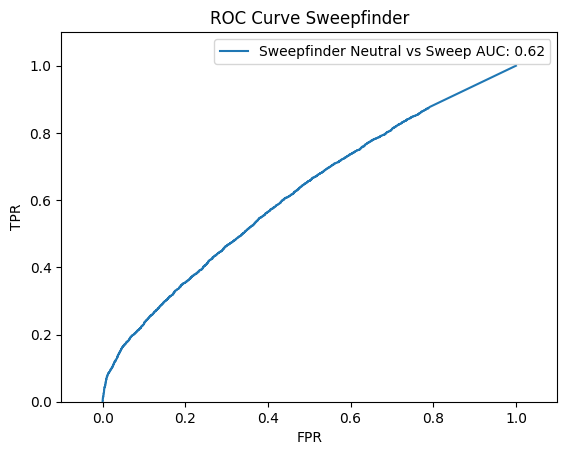

In [35]:
#Sweepfinder
fpr, tpr, thresh = roc_curve(sf["int_swp"], sf["clr"], pos_label=1)
auc_val = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"Sweepfinder Neutral vs Sweep AUC: {auc_val:.2}")

plt.ylim((0,1.1))
plt.xlim((-0.1, 1.1))
plt.title(f"ROC Curve Sweepfinder")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()

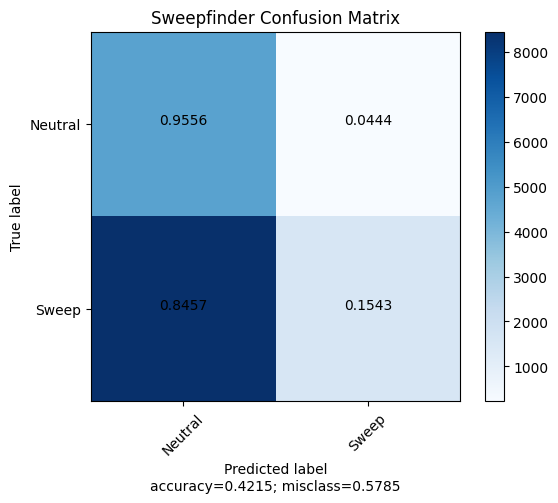

In [36]:
sf["sweep_true"] = np.where(sf["sweep"] == "neut", 0, 1)
sf["sweep_pred"] = np.where(sf["pred"] == "neut", 0, 1)
plot_confusion_matrix(confusion_matrix(sf["sweep_true"], sf["sweep_pred"]), ["Neutral", "Sweep"], title="Sweepfinder", cmap=None, normalize=True)

In [37]:
shic_final.head()
shic_final = shic_final.loc[shic_final["window"] == 5, :]
#lab_dict = {"neut": 0, "hard": 1, "soft": 2, "linkedHard": 3, "linkedSoft": 4}
shic_final["sweep_prob"] = shic_final["soft_prob"] + shic_final["hard_prob"]

shic_final["int_swp"] = np.zeros(len(shic_final))
shic_final.loc[shic_final["sweep"] != "neut", "int_swp"] = 1
shic_final.loc[shic_final["sweep"] == "sdn", "int_swp"] = 2


shic_final
#shic_final["swp_str"] = [lab_dict[i] for i in shic_final["sweep"]]


,rep,sweep,window,pred,neut_prob,softlinked_prob,soft_prob,hard_prob,hardlinked_prob,sweep_prob,int_swp
6,0,neut,5,linkedSoft,0.279204,0.288930,0.095201,0.064958,0.271707,0.160159,0.0
17,1,neut,5,neutral,0.315088,0.303647,0.058153,0.025212,0.297901,0.083365,0.0
28,10,neut,5,neutral,0.312134,0.279790,0.144153,0.018747,0.245175,0.162900,0.0
39,100,neut,5,linkedHard,0.159008,0.184563,0.217320,0.213966,0.225144,0.431286,0.0
49,1000,neut,5,neutral,0.301125,0.271215,0.110792,0.044633,0.272235,0.155425,0.0
...,...,...,...,...,...,...,...,...,...,...,...
164949,995,ssv,5,soft,0.033424,0.040014,0.453505,0.420541,0.052516,0.874046,1.0
164960,996,ssv,5,soft,0.176259,0.183173,0.234276,0.210548,0.195744,0.444824,1.0
164971,997,ssv,5,hard,0.000154,0.000218,0.316236,0.682718,0.000673,0.998954,1.0
164982,998,ssv,5,hard,0.004415,0.004733,0.433601,0.548837,0.008414,0.982438,1.0


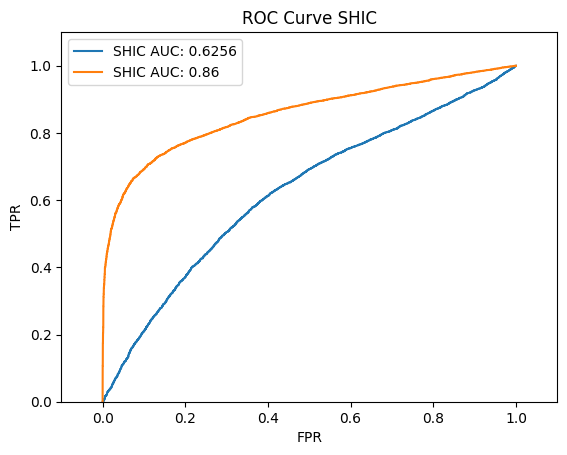

In [38]:
sweep_idxs = np.transpose(np.array((shic_final["int_swp"] > 0)).nonzero())
sweep_labs = np.array(shic_final["int_swp"])[sweep_idxs]

sdn_probs = shic_final[shic_final["int_swp"] > 0]["hard_prob"]

swp_fpr, swp_tpr, thresh = roc_curve(sweep_labs, sdn_probs, pos_label=2)
swp_auc_val = auc(swp_fpr, swp_tpr)
plt.plot(
    swp_fpr,
    swp_tpr,
    label=f"SHIC AUC: {swp_auc_val:.4}",
)

# Coerce all ssvs into sweep binary pred
labs = np.array(shic_final["int_swp"])
labs[labs > 1] = 1

# Plot ROC Curve
fpr, tpr, thresh = roc_curve(labs, shic_final["sweep_prob"])
auc_val = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"SHIC AUC: {auc_val:.2}")

plt.ylim((0,1.1))
plt.xlim((-0.1, 1.1))
plt.title(f"ROC Curve SHIC")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()

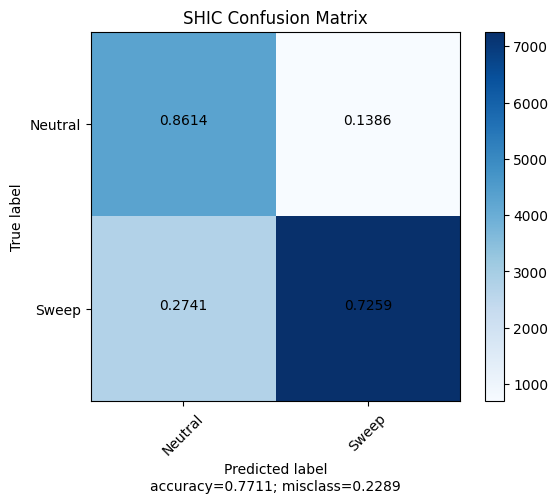

In [39]:
shic_final["sweep_true"] = np.where(shic_final["sweep"] == "neut", 0, 1)
shic_final["sweep_pred"] = np.where((shic_final["pred"] == "hard") | (shic_final["pred"] == "soft"), 1, 0)
plot_confusion_matrix( confusion_matrix(shic_final["sweep_true"], shic_final["sweep_pred"]), ["Neutral", "Sweep"], title="SHIC", cmap=None, normalize=True)

In [40]:
shic_ts["swp_str"] = [lab_dict[i] for i in shic_ts["sweep"]]
shic_ts.head()

,rep,sweep,selcoeff,pred_class,neut_prob,sdn_prob,ssv_prob,sdn_pred_s,ssv_pred_s,swp_str
0,0,neut,0.000000,0,0.504393,0.232063,0.263545,0.079339,0.048689,0
1,0,sdn,0.193895,1,0.016751,0.622572,0.360677,0.133404,0.126946,1
2,0,ssv,0.038933,0,0.472213,0.247185,0.280602,0.067298,0.056548,2
3,1,neut,0.000000,0,0.522556,0.226185,0.251259,0.061646,0.050781,0
4,1,sdn,0.081233,0,0.413132,0.238301,0.348568,0.105258,0.088421,1


[0.4956074  0.98324867 0.52778711 ... 0.41882025 0.99442751 0.95879688]
[0 1 1 ... 0 1 1]


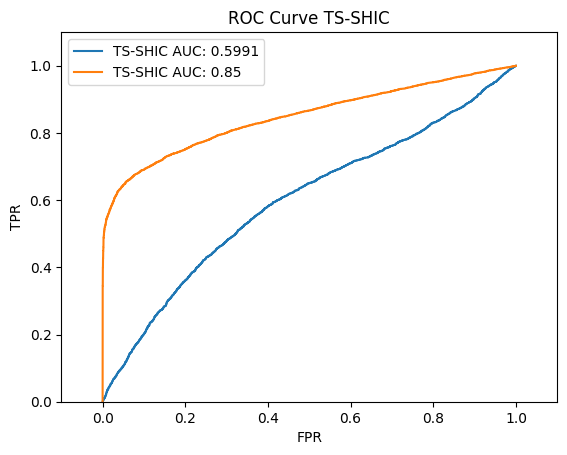

In [41]:
#Timesweeper
sweep_idxs = np.transpose(np.array((shic_ts["swp_str"] > 0)).nonzero())
sweep_labs = np.array(shic_ts["swp_str"])[sweep_idxs]

sdn_probs = shic_ts[shic_ts["swp_str"] > 0]["sdn_prob"]

swp_fpr, swp_tpr, thresh = roc_curve(sweep_labs, sdn_probs, pos_label=1)
swp_auc_val = auc(swp_fpr, swp_tpr)
plt.plot(
    swp_fpr,
    swp_tpr,
    label=f"TS-SHIC AUC: {swp_auc_val:.4}",
)

# Coerce all ssvs into sweep binary pred
labs = np.array(shic_ts["swp_str"])
labs[labs > 1] = 1
pred_probs = np.sum(np.array([shic_ts["sdn_prob"], shic_ts["ssv_prob"]]).T, axis=1)
print(pred_probs)
print(labs)
# Plot ROC Curve
fpr, tpr, thresh = roc_curve(labs, pred_probs)
auc_val = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"TS-SHIC AUC: {auc_val:.2}")

plt.ylim((0,1.1))
plt.xlim((-0.1, 1.1))
plt.title(f"ROC Curve TS-SHIC")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()

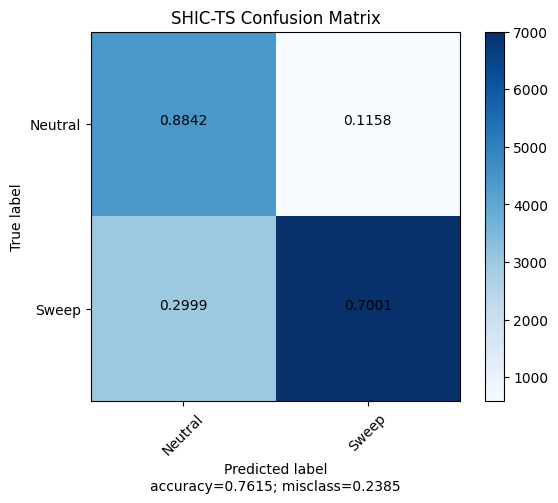

In [42]:
shic_ts["sweep_true"] = np.where(shic_ts["swp_str"] == 0, 0, 1)
shic_ts["sweep_pred"] = np.where(shic_ts["pred_class"] == 0, 0, 1)
plot_confusion_matrix( confusion_matrix(shic_ts["sweep_true"], shic_ts["sweep_pred"]), ["Neutral", "Sweep"], title="SHIC-TS", cmap=None, normalize=True)

In [43]:
stat_mets.dropna(inplace=True)
stat_mets.head()

,rep,sweep,selcoeff,fit_pval,fet_pval
0,0,neut,0.0,0.956060,0.487179
1,1,neut,0.0,0.823239,0.341649
2,10,neut,0.0,0.847260,1.000000
3,100,neut,0.0,0.982759,1.000000
4,1000,neut,0.0,0.942886,1.000000


In [44]:
stat_mets[stat_mets["fet_pval"] < 0.5]


,rep,sweep,selcoeff,fit_pval,fet_pval
0,0,neut,0.000000,0.956060,4.871795e-01
1,1,neut,0.000000,0.823239,3.416493e-01
6,1002,neut,0.000000,0.809311,1.817642e-01
9,1005,neut,0.000000,0.373449,2.307692e-01
11,1007,neut,0.000000,0.574022,1.109695e-01
...,...,...,...,...,...
14992,995_ssv_stat_methods,ssv,0.245783,0.166249,1.450889e-11
14993,996_ssv_stat_methods,ssv,0.165014,0.134075,1.288433e-05
14994,997_ssv_stat_methods,ssv,0.247243,0.088743,1.450889e-11
14995,998_ssv_stat_methods,ssv,0.112594,0.165652,7.708573e-07


In [45]:
stat_mets["fit_score"] = 1 - stat_mets["fit_pval"]
stat_mets["fet_score"] = 1 - stat_mets["fet_pval"]
stat_mets["int_swp"] = np.where(stat_mets["sweep"] == "neut", 0, 1)

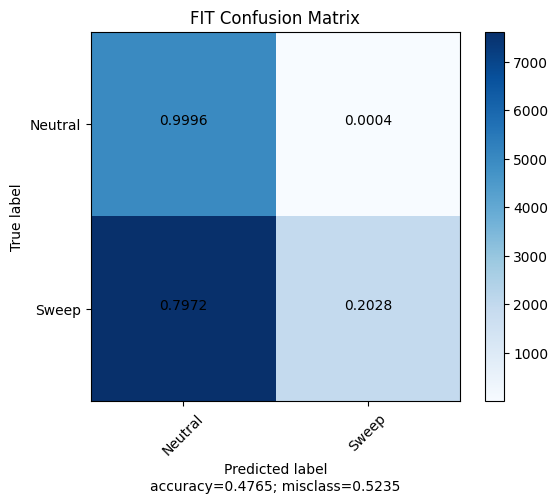

In [46]:
stat_mets["fit_sweep"] = np.where(stat_mets["fit_pval"] < 0.05, 1, 0)
plot_confusion_matrix( confusion_matrix(stat_mets["int_swp"], stat_mets["fit_sweep"]), ["Neutral", "Sweep"], title="FIT", cmap=None, normalize=True)

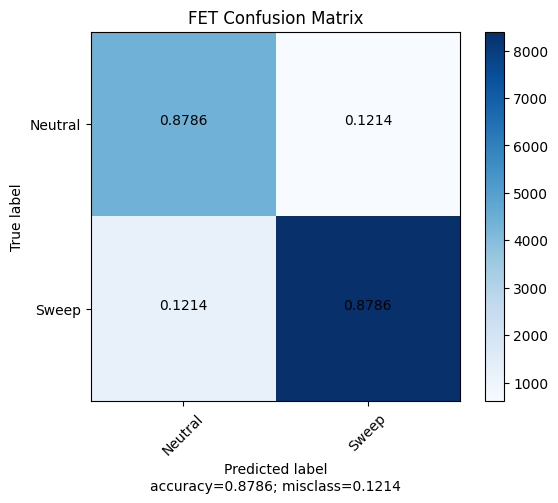

In [47]:
stat_mets["fet_sweep"] = np.where(stat_mets["fet_pval"] < 0.05, 1, 0)
plot_confusion_matrix( confusion_matrix(stat_mets["int_swp"], stat_mets["fet_sweep"]), ["Neutral", "Sweep"], title="FET", cmap=None, normalize=True)

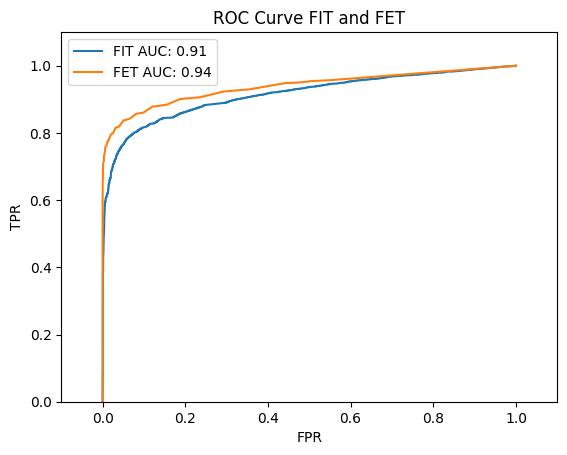

In [48]:
#Sweepfinder
fpr, tpr, thresh = roc_curve(stat_mets["int_swp"], stat_mets["fit_score"], pos_label=1)
auc_val = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"FIT AUC: {auc_val:.2}")

fpr, tpr, thresh = roc_curve(stat_mets["int_swp"], stat_mets["fet_score"], pos_label=1)
auc_val = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"FET AUC: {auc_val:.2}")

plt.ylim((0,1.1))
plt.xlim((-0.1, 1.1))
plt.title(f"ROC Curve FIT and FET")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()

[0.45277647 0.26035475 0.30545893 ... 0.28098581 0.93702793 0.30166202]
[0 0 0 ... 1 1 1]
['Timesweeper AUC: 0.95', 'Timesweeper HFT AUC: 0.87', 'Sweepfinder AUC: 0.62', 'SHIC Neutral vs Sweep AUC: 0.86', 'TS-SHIC AUC: 0.85', 'FIT AUC: 0.91', 'FET AUC: 0.94']


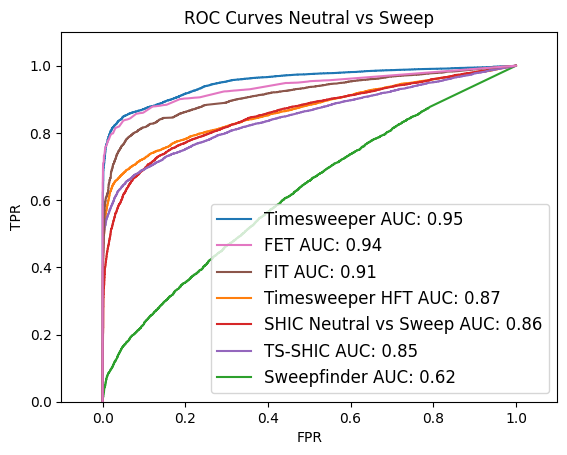

In [49]:
aucs = []
#Neut vs Sweep
#Timesweeper
# Coerce all ssvs into sweep binary pred
labs = np.array(ts["swp_str"])
labs[labs > 1] = 1
pred_probs = np.sum(np.array([ts["sdn_prob"], ts["ssv_prob"]]).T, axis=1)
# Plot ROC Curve
fpr, tpr, thresh = roc_curve(labs, pred_probs)
auc_val = auc(fpr, tpr)
aucs.append(auc_val)
plt.plot(fpr, tpr, label=f"Timesweeper AUC: {auc_val:.2}")

###########
#HFT

# Coerce all ssvs into sweep binary pred
labs = np.array(ts_hft["swp_str"])
labs[labs > 1] = 1
pred_probs = np.sum(np.array([ts_hft["sdn_prob"], ts_hft["ssv_prob"]]).T, axis=1)
print(pred_probs)
print(labs)
# Plot ROC Curve
fpr, tpr, thresh = roc_curve(labs, pred_probs)
auc_val = auc(fpr, tpr)
aucs.append(auc_val)

plt.plot(fpr, tpr, label=f"Timesweeper HFT AUC: {auc_val:.2}")


###########
#Sweepfinder
fpr, tpr, thresh = roc_curve(sf["int_swp"], sf["clr"], pos_label=1)
auc_val = auc(fpr, tpr)
aucs.append(auc_val)
plt.plot(fpr, tpr, label=f"Sweepfinder AUC: {auc_val:.2}")

###########
#SHIC
# Coerce all ssvs into sweep binary pred
labs = np.array(shic_final["int_swp"])
labs[labs > 1] = 1

# Plot ROC Curve
fpr, tpr, thresh = roc_curve(labs, shic_final["sweep_prob"])
auc_val = auc(fpr, tpr)
aucs.append(auc_val)

plt.plot(fpr, tpr, label=f"SHIC Neutral vs Sweep AUC: {auc_val:.2}")

###########
#TS-SHIC
# Coerce all ssvs into sweep binary pred
labs = np.array(shic_ts["swp_str"])
labs[labs > 1] = 1
pred_probs = np.sum(np.array([shic_ts["sdn_prob"], shic_ts["ssv_prob"]]).T, axis=1)
# Plot ROC Curve
fpr, tpr, thresh = roc_curve(labs, pred_probs)
auc_val = auc(fpr, tpr)
aucs.append(auc_val)

plt.plot(fpr, tpr, label=f"TS-SHIC AUC: {auc_val:.2}")

###########
#FIT
fpr, tpr, thresh = roc_curve(stat_mets["int_swp"], stat_mets["fit_score"], pos_label=1)
auc_val = auc(fpr, tpr)
aucs.append(auc_val)

plt.plot(fpr, tpr, label=f"FIT AUC: {auc_val:.2}")

###########
#FET
fpr, tpr, thresh = roc_curve(stat_mets["int_swp"], stat_mets["fet_score"], pos_label=1)
auc_val = auc(fpr, tpr)
aucs.append(auc_val)

plt.plot(fpr, tpr, label=f"FET AUC: {auc_val:.2}")

###########

#Plot 

handles, labels = plt.gca().get_legend_handles_labels()

print(labels)

order = [i for (v, i) in sorted((v, i) for (i, v) in enumerate(aucs))][::-1]

plt.ylim((0,1.1))
plt.xlim((-0.1, 1.1))
plt.title(f"ROC Curves Neutral vs Sweep")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend([handles[i] for i in order], [labels[i] for i in order], fontsize=12)
plt.savefig("comp_methods_sweep_roc.pdf")


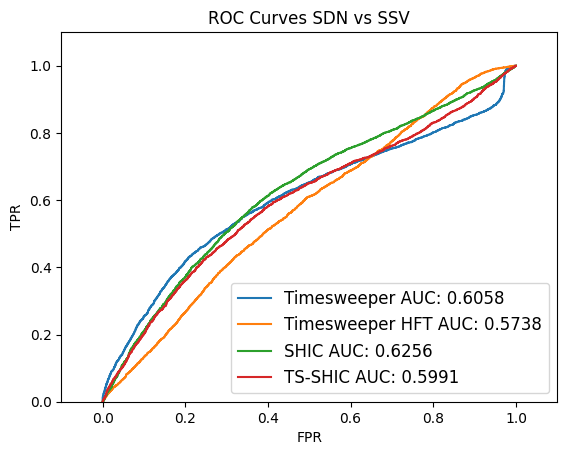

In [50]:
#Timesweeper
plt.clf()
sweep_idxs = np.transpose(np.array((ts["swp_str"] > 0)).nonzero())
sweep_labs = np.array(ts["swp_str"])[sweep_idxs]

sdn_probs = ts[ts["swp_str"] > 0]["sdn_prob"]

swp_fpr, swp_tpr, thresh = roc_curve(sweep_labs, sdn_probs, pos_label=2)
swp_auc_val = auc(swp_fpr, swp_tpr)
plt.plot(
    swp_fpr,
    swp_tpr,
    label=f"Timesweeper AUC: {swp_auc_val:.4}",
)

#HFT
sweep_idxs = np.transpose(np.array((ts_hft["swp_str"] > 0)).nonzero())
sweep_labs = np.array(ts_hft["swp_str"])[sweep_idxs]

sdn_probs = ts_hft[ts_hft["swp_str"] > 0]["sdn_prob"]

swp_fpr, swp_tpr, thresh = roc_curve(sweep_labs, sdn_probs, pos_label=2)
swp_auc_val = auc(swp_fpr, swp_tpr)
plt.plot(
    swp_fpr,
    swp_tpr,
    label=f"Timesweeper HFT AUC: {swp_auc_val:.4}",
)

#SHIC
sweep_idxs = np.transpose(np.array((shic_final["int_swp"] > 0)).nonzero())
sweep_labs = np.array(shic_final["int_swp"])[sweep_idxs]

sdn_probs = shic_final[shic_final["int_swp"] > 0]["hard_prob"]

swp_fpr, swp_tpr, thresh = roc_curve(sweep_labs, sdn_probs, pos_label=2)
swp_auc_val = auc(swp_fpr, swp_tpr)
plt.plot(
    swp_fpr,
    swp_tpr,
    label=f"SHIC AUC: {swp_auc_val:.4}",
)

#TS-SHIC
sweep_idxs = np.transpose(np.array((shic_ts["swp_str"] > 0)).nonzero())
sweep_labs = np.array(shic_ts["swp_str"])[sweep_idxs]

sdn_probs = shic_ts[shic_ts["swp_str"] > 0]["sdn_prob"]

swp_fpr, swp_tpr, thresh = roc_curve(sweep_labs, sdn_probs, pos_label=1)
swp_auc_val = auc(swp_fpr, swp_tpr)
plt.plot(
    swp_fpr,
    swp_tpr,
    label=f"TS-SHIC AUC: {swp_auc_val:.4}",
)
handles, labels = plt.gca().get_legend_handles_labels()

order = [0, 1, 2, 3]
plt.ylim((0,1.1))
plt.xlim((-0.1, 1.1))
plt.title(f"ROC Curves SDN vs SSV")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend([handles[i] for i in order], [labels[i] for i in order], fontsize=12)
plt.savefig("comp_methods_sdnssv_roc.pdf")


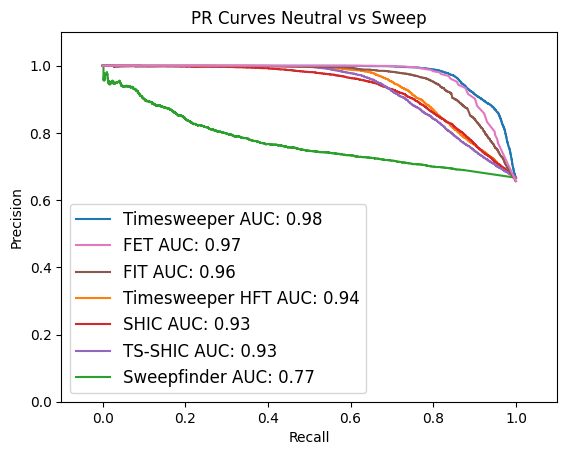

In [51]:
aucs = []
#Neut vs Sweep
#Timesweeper
# Coerce all ssvs into sweep binary pred
labs = np.array(ts["swp_str"])
labs[labs > 1] = 1
pred_probs = np.sum(np.array([ts["sdn_prob"], ts["ssv_prob"]]).T, axis=1)
# Plot ROC Curve
prec, rec, thresh = precision_recall_curve(labs, pred_probs)
auc_val = auc(rec, prec)
aucs.append(auc_val)
plt.plot(rec, prec, label=f"Timesweeper AUC: {auc_val:.2}")

###########
#HFT

# Coerce all ssvs into sweep binary pred
labs = np.array(ts_hft["swp_str"])
labs[labs > 1] = 1
pred_probs = np.sum(np.array([ts_hft["sdn_prob"], ts_hft["ssv_prob"]]).T, axis=1)

# Plot ROC Curve
prec, rec, thresh = precision_recall_curve(labs, pred_probs)
auc_val = auc(rec, prec)
aucs.append(auc_val)

plt.plot(rec, prec, label=f"Timesweeper HFT AUC: {auc_val:.2}")


###########
#Sweepfinder
prec, rec, thresh = precision_recall_curve(sf["int_swp"], sf["clr"], pos_label=1)
auc_val = auc(rec, prec)
aucs.append(auc_val)
plt.plot(rec, prec, label=f"Sweepfinder AUC: {auc_val:.2}")

###########
#SHIC
# Coerce all ssvs into sweep binary pred
labs = np.array(shic_final["int_swp"])
labs[labs > 1] = 1

# Plot ROC Curve
prec, rec, thresh = precision_recall_curve(labs, shic_final["sweep_prob"])
auc_val = auc(rec, prec)
aucs.append(auc_val)

plt.plot(rec, prec, label=f"SHIC AUC: {auc_val:.2}")

###########
#TS-SHIC
# Coerce all ssvs into sweep binary pred
labs = np.array(shic_ts["swp_str"])
labs[labs > 1] = 1
pred_probs = np.sum(np.array([shic_ts["sdn_prob"], shic_ts["ssv_prob"]]).T, axis=1)
# Plot ROC Curve
prec, rec, thresh = precision_recall_curve(labs, pred_probs)
auc_val = auc(rec, prec)
aucs.append(auc_val)

plt.plot(rec, prec, label=f"TS-SHIC AUC: {auc_val:.2}")

###########
#FIT
prec, rec, thresh = precision_recall_curve(stat_mets["int_swp"], stat_mets["fit_score"], pos_label=1)
auc_val = auc(rec, prec)
aucs.append(auc_val)

plt.plot(rec, prec, label=f"FIT AUC: {auc_val:.2}")

###########
#FET
prec, rec, thresh = precision_recall_curve(stat_mets["int_swp"], stat_mets["fet_score"], pos_label=1)
auc_val = auc(rec, prec)
aucs.append(auc_val)

plt.plot(rec, prec, label=f"FET AUC: {auc_val:.2}")

###########

#Plot 

handles, labels = plt.gca().get_legend_handles_labels()

order = [i for (v, i) in sorted((v, i) for (i, v) in enumerate(aucs))][::-1]

plt.ylim((0,1.1))
plt.xlim((-0.1, 1.1))
plt.title(f"PR Curves Neutral vs Sweep")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend([handles[i] for i in order], [labels[i] for i in order], fontsize=12)
plt.savefig("comp_methods_sweep_pr.pdf")


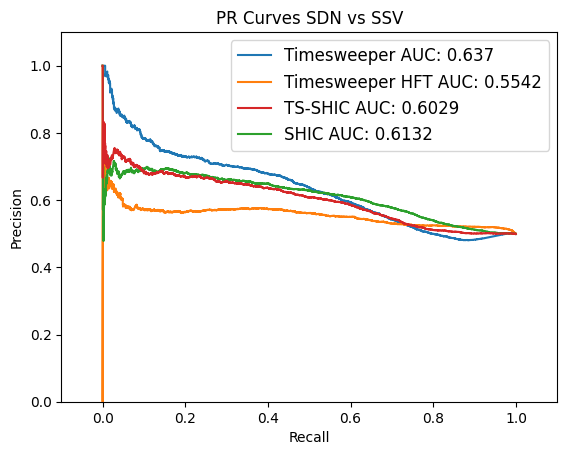

In [52]:
#Timesweeper
plt.clf()
sweep_idxs = np.transpose(np.array((ts["swp_str"] > 0)).nonzero())
sweep_labs = np.array(ts["swp_str"])[sweep_idxs]

sdn_probs = ts[ts["swp_str"] > 0]["sdn_prob"]

prec, rec, thresh = precision_recall_curve(sweep_labs, sdn_probs, pos_label=2)
swp_auc_val = auc(rec, prec)
plt.plot(
    rec,
    prec,
    label=f"Timesweeper AUC: {swp_auc_val:.4}",
)

#HFT
sweep_idxs = np.transpose(np.array((ts_hft["swp_str"] > 0)).nonzero())
sweep_labs = np.array(ts_hft["swp_str"])[sweep_idxs]

sdn_probs = ts_hft[ts_hft["swp_str"] > 0]["sdn_prob"]

prec, rec, thresh = precision_recall_curve(sweep_labs, sdn_probs, pos_label=2)
swp_auc_val = auc(rec, prec)
plt.plot(
    rec,
    prec,
    label=f"Timesweeper HFT AUC: {swp_auc_val:.4}",
)

#SHIC
sweep_idxs = np.transpose(np.array((shic_final["int_swp"] > 0)).nonzero())
sweep_labs = np.array(shic_final["int_swp"])[sweep_idxs]

sdn_probs = shic_final[shic_final["int_swp"] > 0]["hard_prob"]

prec, rec, thresh = precision_recall_curve(sweep_labs, sdn_probs, pos_label=2)
swp_auc_val = auc(rec, prec)
plt.plot(
    rec,
    prec,
    label=f"SHIC AUC: {swp_auc_val:.4}",
)

#TS-SHIC
sweep_idxs = np.transpose(np.array((shic_ts["swp_str"] > 0)).nonzero())
sweep_labs = np.array(shic_ts["swp_str"])[sweep_idxs]

sdn_probs = shic_ts[shic_ts["swp_str"] > 0]["sdn_prob"]

prec, rec, thresh = precision_recall_curve(sweep_labs, sdn_probs, pos_label=1)
swp_auc_val = auc(rec, prec)
plt.plot(
    rec,
    prec,
    label=f"TS-SHIC AUC: {swp_auc_val:.4}",
)
handles, labels = plt.gca().get_legend_handles_labels()

order = [0, 1, 3, 2]
plt.ylim((0,1.1))
plt.xlim((-0.1, 1.1))
plt.title(f"PR Curves SDN vs SSV")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend([handles[i] for i in order], [labels[i] for i in order], fontsize=12)
plt.savefig("comp_methods_sdnssv_pr.pdf")


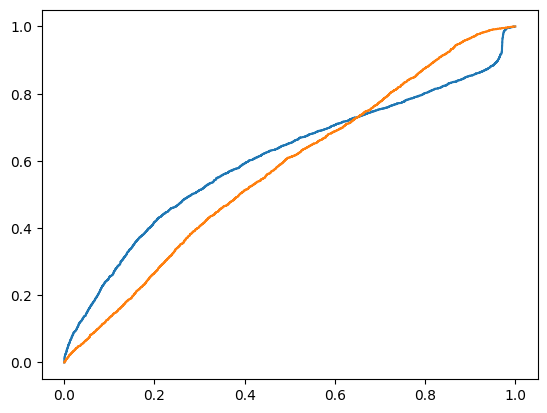

In [53]:
#Timesweeper
plt.clf()
sweep_idxs = np.transpose(np.array((ts["swp_str"] > 0)).nonzero())
sweep_labs = np.array(ts["swp_str"])[sweep_idxs]

sdn_probs = ts[ts["swp_str"] > 0]["sdn_prob"]

swp_fpr, swp_tpr, thresh = roc_curve(sweep_labs, sdn_probs, pos_label=2)
swp_auc_val = auc(swp_fpr, swp_tpr)
plt.plot(
    swp_fpr,
    swp_tpr,
    label=f"Timesweeper SDN vs SSV: {swp_auc_val:.4}",
)

#HFT
sweep_idxs = np.transpose(np.array((ts_hft["swp_str"] > 0)).nonzero())
sweep_labs = np.array(ts_hft["swp_str"])[sweep_idxs]

sdn_probs = ts_hft[ts_hft["swp_str"] > 0]["sdn_prob"]

swp_fpr, swp_tpr, thresh = roc_curve(sweep_labs, sdn_probs, pos_label=2)
swp_auc_val = auc(swp_fpr, swp_tpr)
plt.plot(
    swp_fpr,
    swp_tpr,
    label=f"Timesweeper HFT SDN vs SSV: {swp_auc_val:.4}",
)